### R parallelization: model-based clustering example on bivariate randomly generated data

In [1]:
# This tutorial is about R parallelization and has been inspired from http://glennklockwood.com/di/R-para.php 

rm(list=ls()) #clear workspace

source("genData.R") #loading the data generation function
#install.packages("e1071", lib="/opt/conda/lib/R/library", repo="http://cran.us.r-project.org")
#install.packages("snow", lib="/opt/conda/lib/R/library", repo="http://cran.us.r-project.org")
#install.packages("mclust", lib="/opt/conda/lib/R/library", repo="http://cran.us.r-project.org")
#install.packages("doMC", lib="/opt/conda/lib/R/library", repo="http://cran.us.r-project.org")
#install.packages("foreach", lib="/opt/conda/lib/R/library", repo="http://cran.us.r-project.org")

library(e1071)
library(parallel)
library(foreach)
library(doMC)
library(mclust)
library(snow)
#genData

Loading required package: iterators
Package 'mclust' version 5.2.3
Type 'citation("mclust")' for citing this R package in publications.

Attaching package: ‘snow’

The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, clusterSplit, makeCluster, parApply,
    parCapply, parLapply, parRapply, parSapply, splitIndices,
    stopCluster



### Data generation and data writing

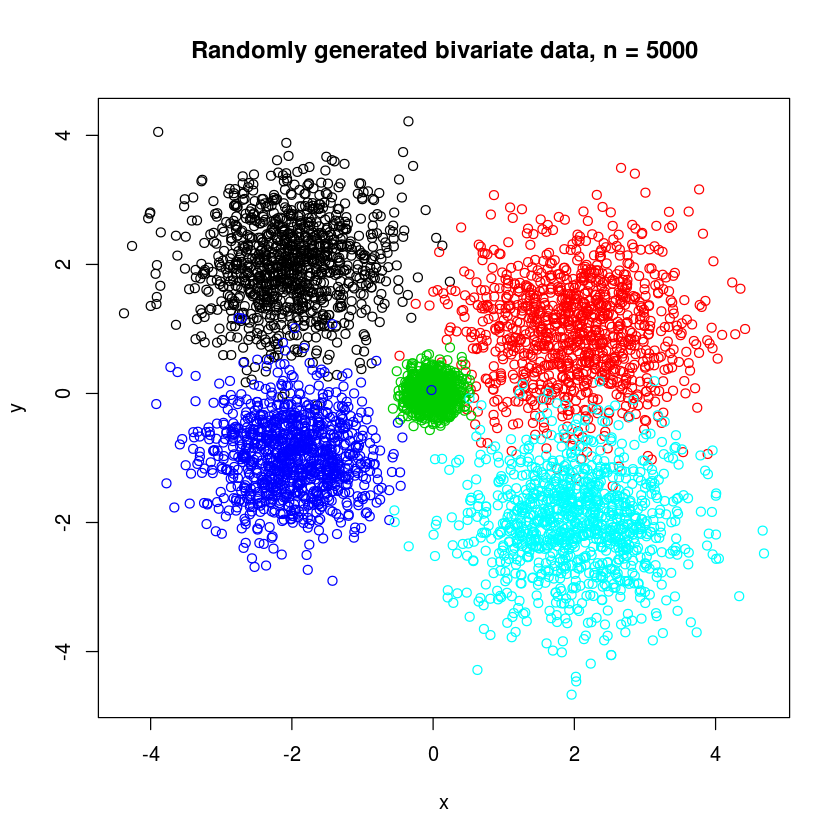

In [2]:
# setting the parameters
nrow <- 1000 # number of obs of each cluster
sd <- c(0.7,0.8,0.2,0.6,0.8) # standard deviation of each cluster
real.centers <- list( x=c(-2, 2, 0.0, -2, +2), y=c(2, 1, 0, -1, -2) ) # the real centers of the clusters
seed=1234 # set seed: in this way the generated data will be replicable

# data generation
data=genData(nrow,sd,real.centers,seed) # total: 5000 bivariate obs (1000 obs for each group)
labels=data$labels
data=data$data

# plot the data
plot(x=data[,1],y=data[,2],col=labels,main=paste("Randomly generated bivariate data, n =",nrow(data) ),xlab="x",ylab="y")

### Definition of the parallelization function 

In [3]:
# parameter matrix: each row is a combination of modelNames and G (see Mclust function)
modelNames=c("EII","EEI","EEE","VVV")
G=4:6
param=expand.grid(G=G,modelNames=modelNames) #12 combinations!
rm(G,modelNames)

# how many cores do we want to exploit during the parallelization?
ncores=ifelse(nrow(param)>16,yes=16,no=nrow(param))

parallel.function <- function(i) { Mclust( data=data, G=as.character(param$G[i]),
                                          modelNames=as.character(param$modelNames[i]),prior=priorControl()) }
# NB: the parallelization will not be about splitting the data, but about choosing the best parameters
# the data are hard-coded in the function, the variables here are "G"(1) and "modelNames"(2)
ncores

[1] 12

## Model names used in the MCLUST package.

### univariateMixture	A vector with the following components: 
- "E": equal variance (one-dimensional) 
- "V": variable variance (one-dimensional)

### multivariateMixture	A vector with the following components: 
- "EII": spherical, equal volume 
- "VII": spherical, unequal volume 
- "EEI": diagonal, equal volume and shape
- "VEI": diagonal, varying volume, equal shape
- "EVI": diagonal, equal volume, varying shape 
- "VVI": diagonal, varying volume and shape 
- "EEE": ellipsoidal, equal volume, shape, and orientation 
- "EEV": ellipsoidal, equal volume and equal shape
- "VEV": ellipsoidal, equal shape 
- "VVV": ellipsoidal, varying volume, shape, and orientation

### singleComponent	A vector with the following components: 
- "X": one-dimensional 
- "XII": spherical 
- "XXI": diagonal 
- "XXX": ellipsoidal

### mclapply (shared-memory parallelism)

Time difference of 4.374916 mins


[1] "bic"            "BIC"            "call"           "classification"
 [5] "d"              "data"           "df"             "G"             
 [9] "hypvol"         "loglik"         "modelName"      "n"             
[13] "parameters"     "uncertainty"    "z"

[1] 5
[1] "VVV"
Direct agreement: 5 of 5 pairs
Cases in matched pairs: 98.02 %


1 2 3 4 5 
1 3 5 2 4

[1] 0.6989635

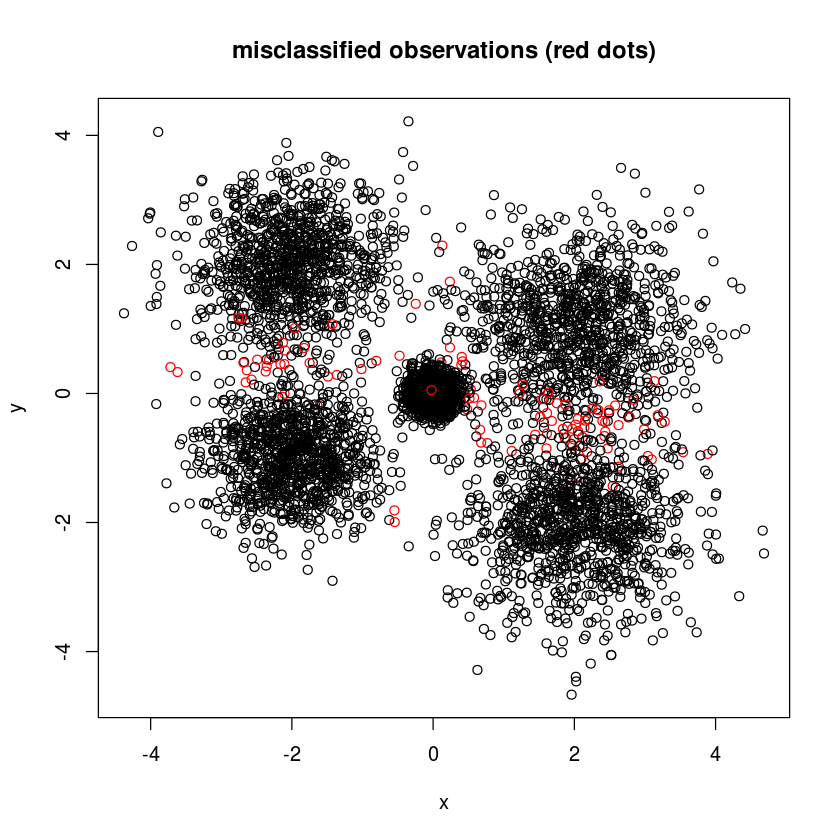

In [4]:
b=Sys.time()
results_list=mclapply((1:nrow(param)),parallel.function,mc.cores=ncores)
e=Sys.time()
mclapply_time=e-b
print(mclapply_time)
mclapply_result=results_list[[which.max(sapply(results_list,function(x){x$bic}))]]
rm(e,b,results_list)

ls(mclapply_result)
print(mclapply_result$G)
print(mclapply_result$modelName)

# matching the results with the actual labels
matchClasses(table(labels,mclapply_result$cl),method="exact")
# entropy of the result
mclapply_entropy=-sum((table(mclapply_result$cl)/length(mclapply_result$cl))*log10(table(mclapply_result$cl)/length(mclapply_result$cl)))
mclapply_entropy
# which obs have been incorrectly classified?
errors=labels
errors[classError(mclapply_result$cl,truth=labels)$misclassified]=2
errors[-classError(mclapply_result$cl,truth=labels)$misclassified]=1
plot(data[,1],data[,2],col=errors,main="misclassified observations (red dots)",xlab="x",ylab="y")

### Running the best model only (no parallelization)

In [5]:
b=Sys.time()
Mclust(data,G=mclapply_result$G,modelNames=mclapply_result$modelName,prior=priorControl())
e=Sys.time()
print(e-b)
rm(b,e)

'Mclust' model object:
 best model: ellipsoidal, varying volume, shape, and orientation (VVV) with 5 components

Time difference of 1.343017 mins


### foreach (shared-memory parallelism)

In [6]:
registerDoMC(ncores) #it is a necessary step in order to make foreach work in parallel

b=Sys.time()
results_list <- foreach(i = 1:nrow(param)) %dopar% parallel.function(i)
e=Sys.time()
doMC_result = results_list[[which.max(sapply(results_list,function(x){x$bic}))]]
doMC_time=e-b
print(doMC_time)
rm(e,b,results_list)

ls(doMC_result)
print(mclapply_result$G)
print(mclapply_result$modelName)

# matching the results with the actual labels
matchClasses(table(labels,doMC_result$cl),method="exact")
# entropy of the result
doMC_entropy=-sum((table(doMC_result$cl)/length(doMC_result$cl))*log10(table(doMC_result$cl)/length(doMC_result$cl)))
doMC_entropy

Time difference of 4.378821 mins


[1] "bic"            "BIC"            "call"           "classification"
 [5] "d"              "data"           "df"             "G"             
 [9] "hypvol"         "loglik"         "modelName"      "n"             
[13] "parameters"     "uncertainty"    "z"

[1] 5
[1] "VVV"
Direct agreement: 5 of 5 pairs
Cases in matched pairs: 98.02 %


1 2 3 4 5 
1 3 5 2 4

[1] 0.6989635